## Decision Tree Notebook for Stellar Object Classification with Gaia DR3

Within this notebook we use a decision tree neural network to predict the type of stellar object based upon the light from a target and its redshift.

The dataset used is from the third release of Gaia data released [(DR3)](https://www.cosmos.esa.int/web/gaia/dr3) on the 13th of June 2022, with this specific dataset consisting of 626,016 stellar objects.

In [1]:
import kagglehub #used to get the data from kaggle.com
from kagglehub import KaggleDatasetAdapter #used to fetch the specific dataset from kaggle
import pandas as pd #used for viewing and manipulating the data
import matplotlib.pyplot as plt #used for data visulisation
import sklearn as skl
from sklearn.model_selection import train_test_split as skl_tts
from sklearn.tree import DecisionTreeClassifier as skl_dtc
from sklearn.metrics import classification_report as skl_cr
from sklearn.metrics import accuracy_score as skl_as
from sklearn.tree import plot_tree as plt_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#DO NOT TOUCH THIS - IT WORKS
import sys, os #imports sys and os, allows for modifying the path to get functions
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), ".."))) #changes the path to include the py folder and its contents (parent folder)

from functions import * #imports all functions into the notebook from functions.py

In [2]:
data = dataGrabber1()

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data.head()

,RA_ICRS,DE_ICRS,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RUWE,Gmag,e_Gmag,BPmag,e_BPmag,RPmag,e_RPmag,GRVSmag,e_GRVSmag,RV,logg,[Fe/H],Dist,PQSO,PGal,Pstar,PWD,Pbin,Teff,A0,AG,ABP,ARP,E(BP-RP),GMAG,Rad,Rad-Flame,Lum-Flame,Mass-Flame,Age-Flame,z-Flame,Evol,SpType-ELS,Flags-HS,EWHa,e_EWHa,f_EWHa,Class
0,44.589012,2.195298,1306361548360576,0.0655,0.0612,0.2384,0.0769,2.901,2.088,0.081,-2.014,0.073,1.079,16.908537,0.002931,16.761435,0.012279,17.134040,0.018818,NaN,NaN,NaN,4.5728,-0.9759,19867.748,0.0,1.160000e-06,0.000050,0.999948,5.000000e-07,18148.611,0.0076,0.0076,0.0088,0.0047,0.0041,0.3894,1.6635,1.7096,298.485140,NaN,NaN,1.507248,NaN,O,92,0.02128,0.19309,0,White Dwarf
1,35.358035,8.988813,23700286669971584,0.0658,0.0717,0.1666,0.0785,4.402,-0.242,0.085,-4.396,0.081,0.940,16.962143,0.002974,16.841173,0.005818,17.193855,0.010486,NaN,NaN,NaN,4.4948,-1.1661,21021.896,0.0,1.530000e-06,0.000050,0.999948,5.000000e-07,17500.236,0.0071,0.0071,0.0082,0.0044,0.0038,0.3548,1.7470,1.8249,292.672100,NaN,NaN,1.332909,NaN,O,92,0.02144,0.17600,0,White Dwarf
2,44.450767,10.079118,27109837867995776,0.0627,0.0517,0.3544,0.0727,3.154,2.722,0.074,1.593,0.064,1.060,16.407494,0.002938,16.382404,0.006835,16.429598,0.010283,NaN,NaN,NaN,4.5526,-0.9919,14943.434,0.0,1.000000e-08,0.000050,0.999950,5.000000e-07,19761.363,0.5045,0.5001,0.5830,0.3134,0.2696,0.0162,1.8439,1.9063,506.732800,NaN,NaN,1.582338,NaN,O,92,0.13726,0.13364,0,White Dwarf
3,48.404909,15.105912,31009771252186752,0.0500,0.0421,0.5962,0.0557,2.745,2.460,0.057,1.218,0.051,1.052,15.607131,0.002964,15.497600,0.009256,15.672352,0.015623,NaN,NaN,NaN,4.5211,-0.9392,11625.332,0.0,0.000000e+00,0.999998,0.000002,0.000000e+00,19486.800,0.2342,0.2343,0.2718,0.1457,0.1260,0.0268,1.8604,0.2579,9.055018,NaN,NaN,1.561845,NaN,O,93,0.09470,0.10548,0,Star
4,57.092838,11.550927,36876009385300352,0.0521,0.0335,0.4507,0.0575,4.918,-2.851,0.070,-4.008,0.045,1.051,16.372738,0.002845,16.354900,0.004597,16.384790,0.006680,NaN,NaN,NaN,4.5807,-0.9965,12459.044,0.0,1.000000e-08,0.000050,0.999950,5.000000e-07,18453.346,0.5265,0.5193,0.6062,0.3267,0.2796,0.3626,1.6652,1.7220,311.502840,NaN,NaN,1.521734,NaN,O,92,0.08682,0.07831,0,White Dwarf


# Choosing features and selecting a target

These are the primary features we are using with our model from the data, as well as the target being the 'Class' of the object - these being a Galaxy (0), Star (1), White Dwarf (2), Binary System (3) or Undefined (4). This can be easily changed however to any column from the dataset.

The features selected are as follows:
- Gmag
- BPmag
- RPmag
- GRVSmag
- z-Flame

In [4]:
#main feature trying to find is subclass (starforming or starburst)
features = data[['Gmag', 'BPmag', 'RPmag', 'GRVSmag', 'GRVSmag']] #, 'z-Flame'
target = data['Class']

In [5]:
test_size = 0.2 #splits the data into 80:20 ratio
random_state = 12 #acts as a seed to ensure same outcome each time
xTrain, xTest, yTrain, yTest = dataSplitting(features, target, test_size, random_state)

In [24]:
max_depth = 100
clf = skl_dtc(max_depth = 10, random_state = 12)
clf.fit(xTrain, yTrain)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,12
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [25]:
yPred = modelEvaluation(clf, xTest, yTest)

Accuracy of the model: 0.974

Classification Report:
               precision    recall  f1-score   support

Binary System       0.11      0.00      0.00      2279
         Star       0.98      1.00      0.99    121641
  White Dwarf       0.81      0.37      0.51      1284

     accuracy                           0.97    125204
    macro avg       0.63      0.46      0.50    125204
 weighted avg       0.96      0.97      0.96    125204



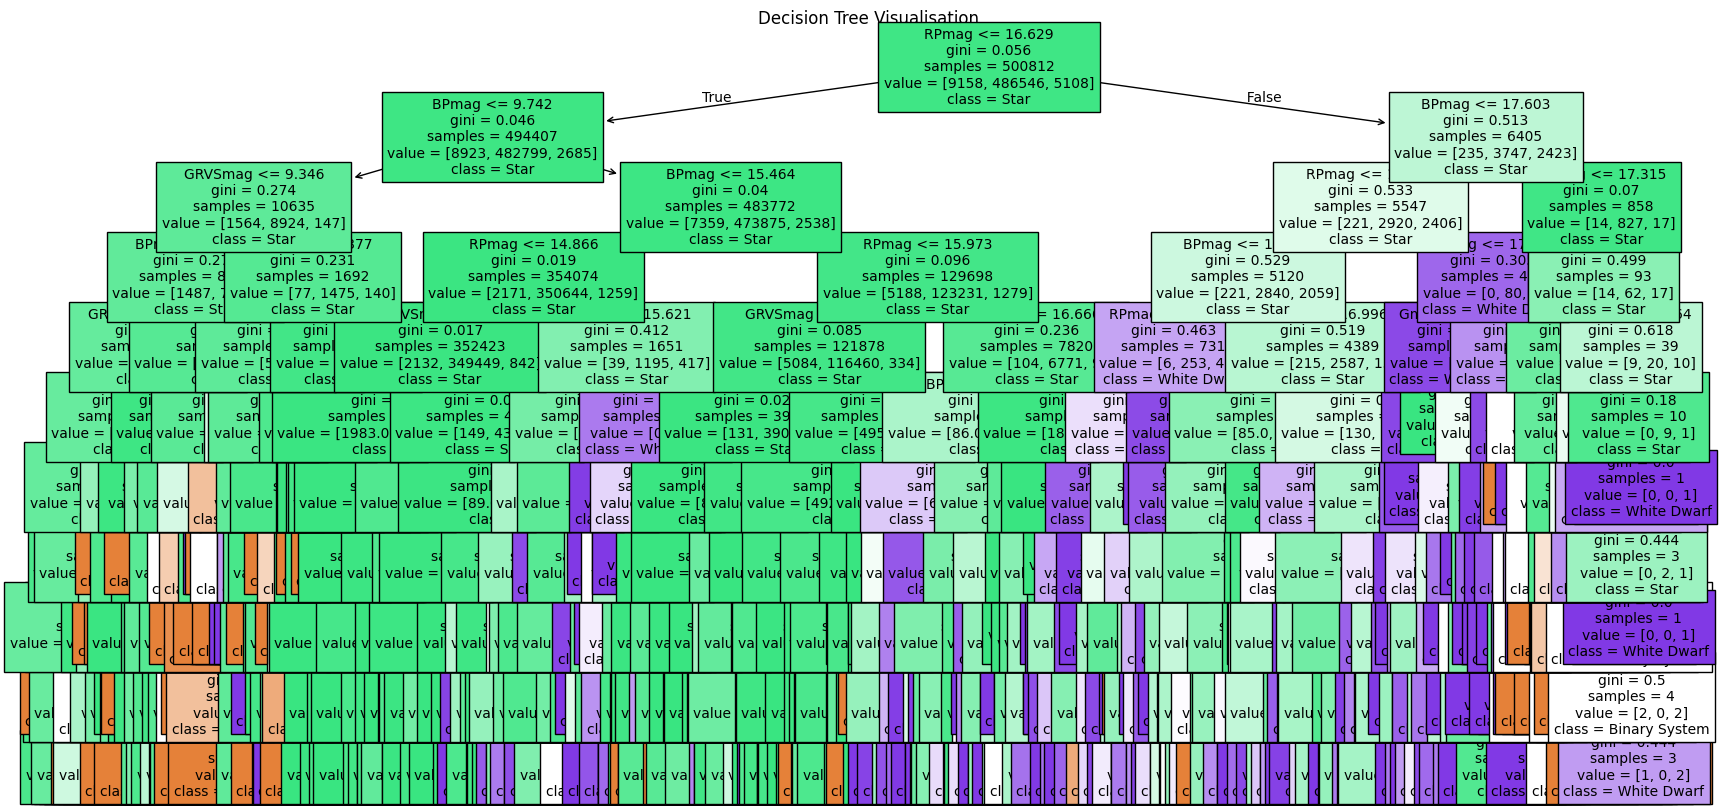

In [26]:
plt.figure(figsize=(20, 10))
plt_tree(clf, feature_names=features.columns, class_names=clf.classes_, filled=True, fontsize=10)
plt.title("Decision Tree Visualisation")
plt.show()

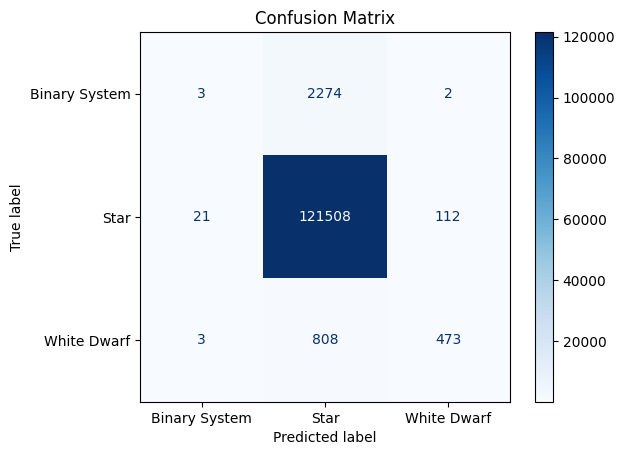

In [27]:
conf_matrix = confusion_matrix(yTest, yPred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')

plt.title("Confusion Matrix")
plt.show()